# Static maps

### Download data

Before we start you need to download (and then extract) the dataset zip-package used during this lesson [from this link](https://github.com/Automating-GIS-processes/Lesson-5-Making-Maps/raw/master/data/dataE5.zip).

You should have following Shapefiles in the `dataE5` folder:

  - addresses.shp
  - metro.shp
  - roads.shp
  - some.geojson
  - TravelTimes_to_5975375_RailwayStation.shp
  - Vaestotietoruudukko_2015.shp

Extract the files into a folder called `data`:

```
    $ cd /home/jovyan/notebooks/L5
    $ wget https://github.com/Automating-GIS-processes/Lesson-5-Making-Maps/raw/master/data/dataE5.zip
    $ unzip dataE5.zip -d data
```

## Static maps in Geopandas

We have already seen during the previous lessons quite many examples how to create static maps using Geopandas.

Thus, we won't spend too much time repeating making such maps but let's create a one with more layers on it than just one which kind we have mostly done this far.

- Let's create a static accessibility map with roads and metro line on it.


In [1]:
import geopandas as gpd
import matplotlib.pyplot as plt
%matplotlib inline

# Filepaths
grid_fp = "data/TravelTimes_to_5975375_RailwayStation.shp"
roads_fp = "data/roads.shp"
metro_fp = "data/metro.shp"

# Read files
grid = gpd.read_file(grid_fp)
roads = gpd.read_file(roads_fp)
metro = gpd.read_file(metro_fp)

Next, we need to be sure that the files are in the same coordinate system. 

- Let's use the crs of our travel time grid as basis:

In [2]:
# Get the CRS of the grid
CRS = grid.crs

# Reproject geometries using the crs of travel time grid
roads['geometry'] = roads['geometry'].to_crs(crs=CRS)
metro['geometry'] = metro['geometry'].to_crs(crs=CRS)

- Finally we can make a visualization using the `.plot()` -function in Geopandas.

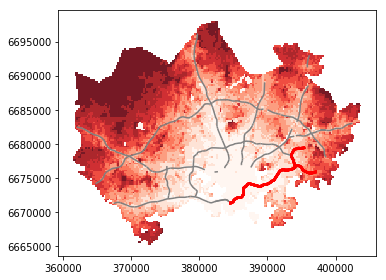

In [42]:
# Visualize the travel times into 9 classes using "Quantiles" classification scheme
# Add also a little bit of transparency with `alpha` parameter
# (ranges from 0 to 1 where 0 is fully transparent and 1 has no transparency)
my_map = grid.plot(column="car_r_t", linewidth=0.03, cmap="Reds", scheme="quantiles", k=9, alpha=0.9)

# Add roads on top of the grid
# (use ax parameter to define the map on top of which the second items are plotted)
roads.plot(ax=my_map, color="grey", linewidth=1.5)

# Add metro on top of the previous map
metro.plot(ax=my_map, color="red", linewidth=2.5)

# Remove the empty white-space around the axes
plt.tight_layout()

# Save the figure as png file with resolution of 300 dpi
outfp = "static_map.png"
plt.savefig(outfp, dpi=300)

## Adding basemap from external source

It is often useful to add a basemap to your visualization that shows e.g. streets and their names and other useful information directly underneath your visualization. This can be done easily by using ready-made background map tiles that are provided by different providers such as [OpenStreetMap](https://wiki.openstreetmap.org/wiki/Tiles) or [Stamen Design](http://maps.stamen.com). A Python library called [contextily](https://github.com/darribas/contextily) is a handy package that can be used to fetch geospatial raster files and add them to your maps. Map tiles are typically distributed in [Web Mercator projection (EPSG:3857)](http://spatialreference.org/ref/sr-org/epsg3857-wgs84-web-mercator-auxiliary-sphere/), hence it is necessary to reproject all the spatial data into [Web Mercator](https://en.wikipedia.org/wiki/Web_Mercator_projection) before visualizing the data.

In this tutorial, we will see how to add a basemap underneath our previous visualization.

- First, we need to read data and reproject it to ESPG 3857 projection (Web Mercator)

In [4]:
import geopandas as gpd
import matplotlib.pyplot as plt
import contextily as ctx
%matplotlib inline

# Filepaths
grid_fp = "data/TravelTimes_to_5975375_RailwayStation.shp"

# Read data
grid = gpd.read_file(grid_fp)

# Reproject to EPSG 3857
data = grid.to_crs(epsg=3857)
print(data.crs)
print(data.head(2))

{'init': 'epsg:3857', 'no_defs': True}
   car_m_d  car_m_t  car_r_d  car_r_t  from_id  pt_m_d  pt_m_t  pt_m_tt  \
0    32297       43    32260       48  5785640   32616     116      147   
1    32508       43    32471       49  5785641   32822     119      145   

   pt_r_d  pt_r_t  pt_r_tt    to_id  walk_d  walk_t  \
0   32616     108      139  5975375   32164     459   
1   32822     111      133  5975375   29547     422   

                                            geometry  
0  POLYGON ((2767221.645887391 8489079.100944027,...  
1  POLYGON ((2767726.328605124 8489095.52034446, ...  


Now as we can see, the data has been projected to `epsg:3857` that can be confirmed by looking at the coordinate values in `geometry` column (they are now represented in metric system).

- Next, we can plot our data using Geopandas and add a basemap for our plot by using a function called `.add_basemap()` from contextily:

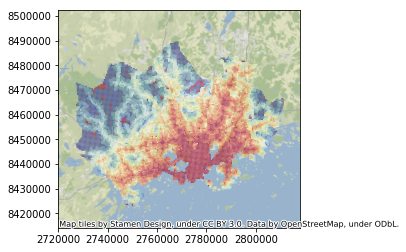

In [7]:
# Plot the data
ax = data.plot(column='pt_r_t', cmap='RdYlBu', linewidth=0, scheme="quantiles", k=9, alpha=0.6)

# Add basemap 
ctx.add_basemap(ax)

As we can see, now the map has a background map that is by default using a style `ST_Terrain` fetched from [Stymen Design](http://maps.stamen.com/#terrain). 

However, there are various other possible data sources and styles that can be used. 

- `tile_providers` contain some of the basic url-addresses for different providers and styles that can be used to control the appearence of your background map:

In [18]:
print(dir(ctx.tile_providers))

['OSM_A', 'OSM_B', 'OSM_C', 'ST_TERRAIN', 'ST_TERRAIN_BACKGROUND', 'ST_TERRAIN_LABELS', 'ST_TERRAIN_LINES', 'ST_TONER', 'ST_TONER_BACKGROUND', 'ST_TONER_HYBRID', 'ST_TONER_LABELS', 'ST_TONER_LINES', 'ST_TONER_LITE', 'ST_WATERCOLOR', '__builtins__', '__cached__', '__doc__', '__file__', '__loader__', '__name__', '__package__', '__spec__']


Here, all the names written in capital letters are the ones that can be used as different basemap styles. All names starting with `ST_` are from Stamen Design, and the `OSM_A` (B and C) are a basic map tile style provided by OpenStreetMap. Notice that the letters A, B, and C are only directing to different tile servers, they are not changing the style. It is also possible to pass other tile providers by passing in the url for the tile provider that you are interested in.

- It is possible to change the tile provider by passing an address to the tile providers' web address using `url` -parameter in `add_basemap()`. Let's see how we can change the style to `OSM_A` which gives us a background map based on OpenStreetMap:

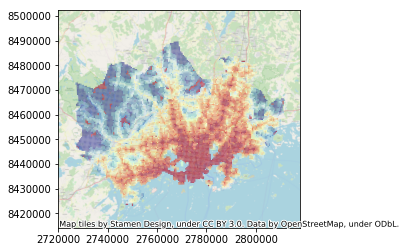

In [22]:
# Plot the data
ax = data.plot(column='pt_r_t', cmap='RdYlBu', linewidth=0, scheme="quantiles", k=9, alpha=0.6)

# Add basemap with `ST_TONER` style
ctx.add_basemap(ax, url=ctx.tile_providers.OSM_A)

As we can see, now the background map changed a bit compared to the earlier one as it was fetched from OpenSteetMap. 

- Let's take a subset of our data to see a bit better the background map characteristics. 

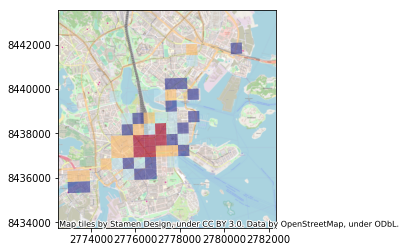

In [41]:
# Take only grid cells with `pt_r_t` travel time values ranging from 0-10
subset = data.loc[(data['pt_r_t']>=0) & (data['pt_r_t']<=10)]

# Plot the data from subset
ax = subset.plot(column='pt_r_t', cmap='RdYlBu', linewidth=0, scheme="quantiles", k=9, alpha=0.6)

# Add basemap with `OSM_A` style
ctx.add_basemap(ax, url=ctx.tile_providers.OSM_A)

As we can see now our map has much more details in it as the zoom level of the background map is larger. By default `contextily` sets the zoom level automatically but it is possible to also control that manually using parameter `zoom`. The zoom level is by default specified as `auto` but you can control that by passing in [zoom level](https://wiki.openstreetmap.org/wiki/Zoom_levels) as numbers ranging typically from 1 to 19 (the larger the number, the more details your basemap will have).

- Let's reduce the level of detail from our map by passing `zoom=11`:

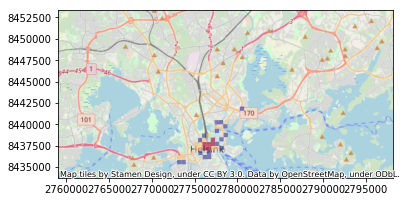

In [30]:
# Plot the data from subset
ax = subset.plot(column='pt_r_t', cmap='RdYlBu', linewidth=0, scheme="quantiles", k=9, alpha=0.6)

# Add basemap with `OSM_A` style using zoom level of 11
ctx.add_basemap(ax, zoom=11, url=ctx.tile_providers.OSM_A)

As we can see, the map has now less detail but it also zoomed out the view from our data.

- We can use `ax.set_xlim()` and `ax.set_ylim()` -parameters to crop our map. The parameters takes as input the coordinates for minimum and maximum on both axis (x and y). We can also change / remove the contribution text by using parameter `attribution`:

(8435000, 8442500)

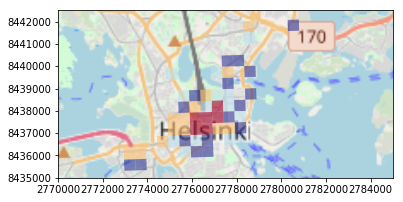

In [28]:
# Plot the data from subset
ax = subset.plot(column='pt_r_t', cmap='RdYlBu', linewidth=0, scheme="quantiles", k=9, alpha=0.6)

# Add basemap with `OSM_A` style using zoom level of 11 
# Remove the attribution info by passing empty string into it
ctx.add_basemap(ax, zoom=11, attribution="", url=ctx.tile_providers.OSM_A)

# Crop the figure
ax.set_xlim(2770000, 2785000)
ax.set_ylim(8435000, 8442500)

As we can see now the image was cropped to fit better the extent of our data. 

It is also possible to use many other map tiles from different providers as the background map. A good list of different available sources can be found from [here](http://leaflet-extras.github.io/leaflet-providers/preview/). When using map tiles from different sources, it is necessary to parse a url address to the tile provider following a format defined by the provider. 

Next, we will see how to use map tiles provided by CartoDB. To do that we need to parse the url address following their [definition](https://github.com/CartoDB/basemap-styles#1-web-raster-basemaps) `'https://{s}.basemaps.cartocdn.com/{style}/{z}/{x}/{y}{r}.png'` where:

 - {s}: one of the available subdomains, either [a,b,c,d]
 - {z} : Zoom level. We support from 0 to 20 zoom levels in OSM tiling system.
 - {x},{y}: Tile coordinates in OSM tiling system
 - {scale}: OPTIONAL "@2x" for double resolution tiles
 - {style}: Map style, possible value is one of:
 
    - light_all,
    - dark_all,
    - light_nolabels,
    - light_only_labels,
    - dark_nolabels,
    - dark_only_labels,
    - rastertiles/voyager,
    - rastertiles/voyager_nolabels,
    - rastertiles/voyager_only_labels,
    - rastertiles/voyager_labels_under
    
- We will use this information to parse the parameters in a way that contextily wants them:

(8435000, 8442500)

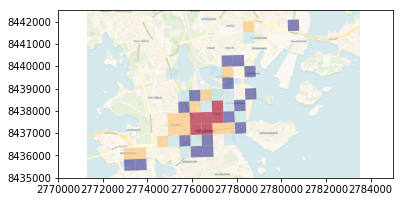

In [40]:
# The formatting should follow: 'https://{s}.basemaps.cartocdn.com/{style}/{z}/{x}/{y}{r}.png'
# Specify the style to use
style = "rastertiles/voyager"
cartodb_url = 'https://a.basemaps.cartocdn.com/%s/tileZ/tileX/tileY.png' % style

# Plot the data from subset
ax = subset.plot(column='pt_r_t', cmap='RdYlBu', linewidth=0, scheme="quantiles", k=9, alpha=0.6)
    
# Add basemap with `OSM_A` style using zoom level of 14 
# Remove the attribution info by passing empty string into it
ctx.add_basemap(ax, zoom=14, attribution="", url=cartodb_url)

# Crop the figure
ax.set_xlim(2770000, 2785000)
ax.set_ylim(8435000, 8442500)

As we can see now we have yet again different kind of background map, now coming from CartoDB. 

- Let's make a minor modification and change the style from `"rastertiles/voyager"` to `"dark_all"`:

(8435000, 8442500)

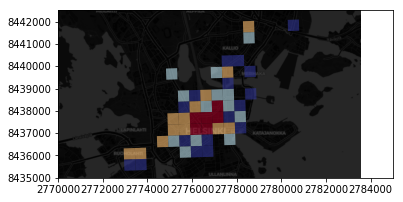

In [39]:
# The formatting should follow: 'https://{s}.basemaps.cartocdn.com/{style}/{z}/{x}/{y}{r}.png'
# Specify the style to use
style = "dark_all"
cartodb_url = 'https://a.basemaps.cartocdn.com/%s/tileZ/tileX/tileY.png' % style

# Plot the data from subset
ax = subset.plot(column='pt_r_t', cmap='RdYlBu', linewidth=0, scheme="quantiles", k=9, alpha=0.6)

# Add basemap with `OSM_A` style using zoom level of 14 
# Remove the attribution info by passing empty string into it
ctx.add_basemap(ax, zoom=13, attribution="", url=cartodb_url)

# Crop the figure
ax.set_xlim(2770000, 2785000)
ax.set_ylim(8435000, 8442500)

Great! Now we have dark background map fetched from CartoDB. In a similar manner, you can use any map tiles from various other tile providers such as the ones listed in [leaflet-providers](http://leaflet-extras.github.io/leaflet-providers/preview/).